In [1]:
from kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std


In [2]:
SEED = 2021
SAMPLES = 256
HDIMS = 2 # 1-qubit models
np.random.seed(SEED)

In [92]:
# make an edesign and simulate the data
target_model = std.target_model('CPTP')
maxLengths = [1]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
maxlength_circ_list = maxlength_edesign.circuit_lists[-1]

In [203]:
target_model.num_params

60

In [93]:
# #calculate jacobians 
# jdict = dict()

# for circ in tqdm(maxlength_circ_list):
#     jdict[circ] = matrix_from_jacob(target_model.sim.dprobs(circ), 2**circ.width)
        
# pickle_dict(jdict, 'observability_jacs')

In [94]:
jdict = load_dict('observability_jacs')

In [212]:
def total_design_matrix(model, circuit_list):
    dmat = np.zeros((0, model.num_params))
    for circ in tqdm(circuit_list):
        jmat = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        dmat = np.vstack([dmat, jmat])
    return dmat

In [96]:
Htot = total_design_matrix(target_model, maxlength_circ_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 16.88it/s]


(184, 60)


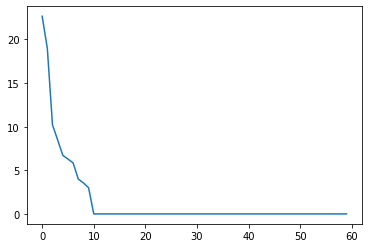

In [97]:
print(Htot.shape)
U, S, Vt = np.linalg.svd(Htot)
plt.plot(S)

In [178]:
print(len(S))
eps = 1e-9
nonzero_svals = [s for s in S if s > eps]
print(len(nonzero_svals))
for s in S[18:]:
    assert s < eps

60
18


In [179]:
Vt.shape

(60, 60)

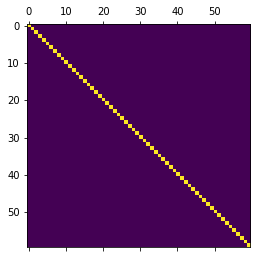

In [180]:
# construct projector onto the nullspace of the design matrix 
V = Vt.T

nullpart = np.zeros(V.shape)
for idx, s in enumerate(S):
    if s < eps:
        nullpart[:, idx] = V[:, idx]
obspart = np.zeros(V.shape)
for idx, s in enumerate(S):
    if s >= eps:
        obspart[:, idx] = V[:, idx]
        
proj_nullspace = V@nullpart.T
proj_obs = V@obspart.T
plt.matshow(proj_nullspace+proj_obs)

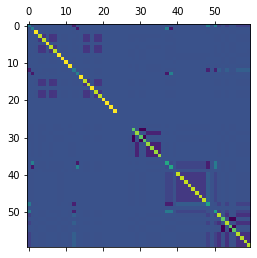

In [186]:
plt.matshow(proj_nullspace@proj_nullspace)

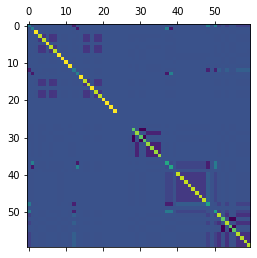

In [187]:
plt.matshow(proj_nullspace@proj_nullspace)

In [182]:
assert np.all( abs(proj_nullspace@proj_nullspace - proj_nullspace) < 0.000001 )

In [183]:
np.max(Htot@proj_nullspace)

1.942816937370492e-15

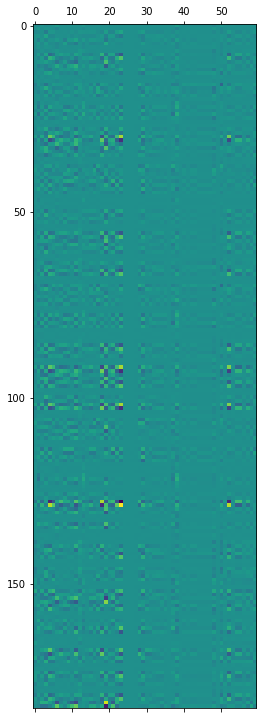

In [184]:
plt.matshow(Htot@proj_nullspace)

In [198]:
# see what happens when you combine model jacs with obs_projectors
print(max([np.max(abs(jdict[circ] - jdict[circ]@proj_obs)) for circ in jdict.keys()]))
# I find the obs_projector does not change the jacobian

2.55351295663786e-15


# compare numbers with fogi models 

In [221]:
# setup a fogi model
hs_target_model = std.target_model('H+s')
fogi_target_model = hs_target_model.copy()
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, fogi_target_model.state_space, elementary_errorgen_types='HS')
print(hs_target_model.num_params)
fogi_target_model.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
print(fogi_target_model.num_params)

30
18


In [222]:
hs_target_model.num_params

30

In [223]:
Htot = total_design_matrix(hs_target_model, maxlength_circ_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 30.89it/s]


In [224]:
Htot.shape

(184, 30)

(184, 30)


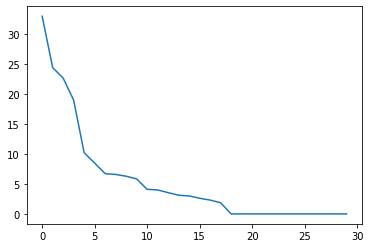

In [225]:
print(Htot.shape)
U, S, Vt = np.linalg.svd(Htot)
plt.plot(S)

In [226]:
print(len(S))
eps = 1e-3
nonzero_svals = [s for s in S if s > eps]
print(len(nonzero_svals))
for s in S[18:]:
    assert s < eps

30
18


In [227]:
Vt.shape

(30, 30)

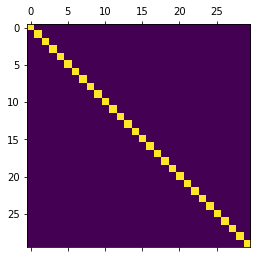

In [228]:
# construct projector onto the nullspace of the design matrix 
V = Vt.T

nullpart = np.zeros(V.shape)
for idx, s in enumerate(S):
    if s < eps:
        nullpart[:, idx] = V[:, idx]
obspart = np.zeros(V.shape)
for idx, s in enumerate(S):
    if s >= eps:
        obspart[:, idx] = V[:, idx]
        
proj_nullspace = V@nullpart.T
proj_obs = V@obspart.T
plt.matshow(proj_nullspace+proj_obs)

# Compare projectors at target with projectors at other spots


In [232]:
def nullspace_projector(total_design_matrix):
    U, S, Vt = np.linalg.svd(total_design_matrix)
    V = Vt.T

    nullpart = np.zeros(V.shape)
    for idx, s in enumerate(S):
        if s < eps:
            nullpart[:, idx] = V[:, idx]

    return V@nullpart.T

In [234]:
target_model = std.target_model('CPTP')
maxLengths = [1]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
circ_list = maxlength_edesign.circuit_lists[-1]
target_design = total_design_matrix(target_model, circ_list)
target_projector = nullspace_projector(target_design)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 17.14it/s]


In [243]:
num_models = 3
max_erate = 0.9
distances = []
for i in range(num_models):
    rmodel = target_model.copy()
    rmodel.from_vector(max_erate*np.random.rand(target_model.num_params))
    rdmat = total_design_matrix(rmodel, circ_list)
    r_ns_proj = nullspace_projector(rdmat)
    distances.append(np.linalg.norm(r_ns_proj - target_projector))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:06<00:00, 14.70it/s]


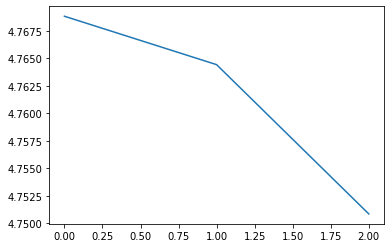

In [244]:
plt.plot(distances)

In [245]:
for i in range(num_models

SyntaxError: incomplete input (4028005470.py, line 1)